<a href="https://colab.research.google.com/github/Mike030668/MIPT_magistratura/blob/main/CV_Gan/gan_hw_uncond_penalty.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### WGAN

* Модифицируйте код ячеек ниже и реализуйте [Wasserstein GAN](https://arxiv.org/abs/1701.07875) с клиппингом весов. (10 баллов)

* Замените клиппинг весов на [штраф градентов](https://arxiv.org/pdf/1704.00028v3.pdf). (10 баллов)

* Добавьте лейблы в WGAN, тем самым решая задачу [условной генерации](https://arxiv.org/pdf/1411.1784.pdf). (30 баллов)

Добавьте в этот файл анализ полученных результатов с различными графиками обучения и визуализацию генерации. Сравните как работает клиппинг весов и штраф градиентов и попробуйте пронаблюдать какие недостатки имеет модель GAN.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

import torchvision
import matplotlib.pyplot as plt
import numpy as np

from torch.autograd import Variable

### Простой конфиг (для хранения параметров, можете использовать и модифицировать)

In [ ]:
class Config:
    pass

config = Config()
config.mnist_path = None
config.batch_size = 16
config.num_workers = 3
config.num_epochs = 10
config.noise_size = 50
config.print_freq = 500

### Создаем dataloader

In [ ]:
train = torchvision.datasets.FashionMNIST("fashion_mnist",
                                          train=True,
                                          transform=torchvision.transforms.ToTensor(),
                                          download=True)

100%|██████████| 26421880/26421880 [00:02<00:00, 11560343.72it/s]


Extracting fashion_mnist/FashionMNIST/raw/train-images-idx3-ubyte.gz to fashion_mnist/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 204785.84it/s]


Extracting fashion_mnist/FashionMNIST/raw/train-labels-idx1-ubyte.gz to fashion_mnist/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 3897589.03it/s]


Extracting fashion_mnist/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to fashion_mnist/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 20466613.26it/s]


Extracting fashion_mnist/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to fashion_mnist/FashionMNIST/raw



In [ ]:
dataloader = DataLoader(train, batch_size=16, shuffle=True)
len(dataloader)

3750

In [ ]:
image, label = next(iter(dataloader))
image.size(), label

(torch.Size([16, 1, 28, 28]),
 tensor([1, 5, 5, 4, 7, 5, 3, 6, 1, 6, 7, 8, 6, 2, 2, 9]))

### Создаем модель GAN

In [ ]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(config.noise_size, 200),
            nn.ReLU(inplace=True),
            nn.Linear(200, 28*28),
            nn.Sigmoid() # if remove then criterion = nn.BCEWithLogitsLoss()
            )

    def forward(self, x):
        return self.model(x)

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(28*28, 200),
            nn.ReLU(inplace=True),
            nn.Linear(200, 50),
            nn.ReLU(inplace=True),
            nn.Linear(50, 1),
            nn.Sigmoid() # if remove then criterion = nn.BCEWithLogitsLoss()
            )
    def forward(self, x):
        return self.model(x)

In [ ]:
generator = Generator()
discriminator = Discriminator()

### Оптимизатор и функция потерь

In [ ]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
generator = generator.to(DEVICE)
discriminator = discriminator.to(DEVICE)
optim_G = optim.Adam(params=generator.parameters(), lr=0.0001)
optim_D = optim.Adam(params=discriminator.parameters(), lr=0.0001)

criterion = nn.BCELoss()
#criterion = nn.BCEWithLogitsLoss() #if remove sigmoid

### Для оптимизации процесса обучения можно заранее определить переменные и заполнять их значения новыми данными

In [ ]:
noise = Variable(torch.FloatTensor(config.batch_size, config.noise_size).to(DEVICE))
fixed_noise = Variable(torch.FloatTensor(config.batch_size, config.noise_size).to(DEVICE).normal_(0, 1))
label = Variable(torch.FloatTensor(config.batch_size).to(DEVICE))
real_label = 1
fake_label = 0

### GAN обучение с gradient_penalty весов D

In [ ]:
from torch import autograd

def compute_gradient_penalty(critic, real_samples, fake_samples):
    Tensor = torch.cuda.FloatTensor
    """Calculates the gradient penalty loss for WGAN GP"""
    # Random weight term for interpolation between real and fake samples
    alpha = torch.rand(real_samples.size(0), 1).to(DEVICE)

    # Get random interpolation between real and fake samples
    interpolates = (alpha * real_samples + ((1 - alpha) * fake_samples)).requires_grad_(True)
    d_interpolates = critic(interpolates)
    fake = Variable(Tensor(real_samples.shape[0], 1).fill_(1.0), requires_grad=False)

    # Get gradient w.r.t. interpolates
    gradients = autograd.grad(
        outputs=d_interpolates,
        inputs=interpolates,
        grad_outputs=fake,
        create_graph=True,
        retain_graph=True,
        only_inputs=True,
    )[0]
    gradients = gradients.view(gradients.size(0), -1)
    gradient_penalty = ((gradients.norm(2, dim=1)) ** 2 -1).mean()
    return gradient_penalty

IMG_ROWS,IMG_COLS = 28, 28

def plot_gen_images(gen_tensor, cmap="Blues"):
    # Plot the sample images now
    f, ax = plt.subplots(4,4, figsize=(7,7))
    for i in range(gen_tensor.shape[0]):
        gen_img = gen_tensor[i].detach().cpu().numpy()
        ax[i//4, i%4].imshow(gen_img.reshape(IMG_ROWS,IMG_COLS), cmap=cmap)
        ax[i//4, i%4].axis('off')
    plt.show()

Epoch:1 Iter: 500 errD_x: 0.43 errD_z: 1.25 g_penalty: 10.96 errG: 2.33
Epoch:1 Iter: 1000 errD_x: 0.55 errD_z: 0.16 g_penalty: 31.93 errG: 2.33
Epoch:1 Iter: 1500 errD_x: 0.16 errD_z: 0.19 g_penalty: 24.49 errG: 2.90
Epoch:1 Iter: 2000 errD_x: 0.68 errD_z: 0.16 g_penalty: 22.42 errG: 2.15
Epoch:1 Iter: 2500 errD_x: 0.46 errD_z: 0.37 g_penalty: 50.05 errG: 1.89
Epoch:1 Iter: 3000 errD_x: 0.18 errD_z: 0.13 g_penalty: 21.73 errG: 2.27
Epoch:1 Iter: 3500 errD_x: 0.85 errD_z: 0.13 g_penalty: 54.64 errG: 2.58


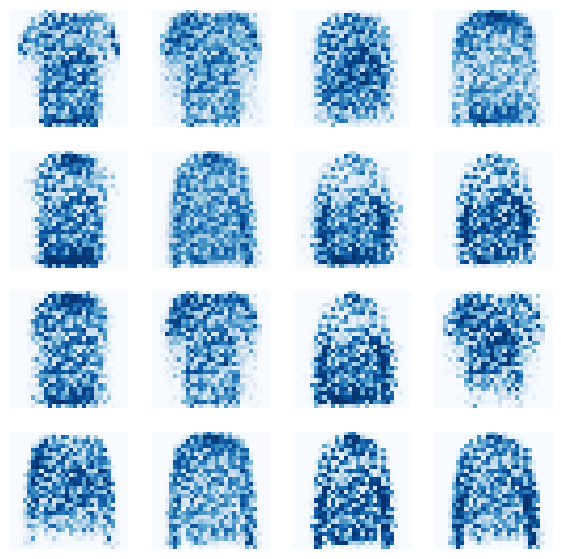

Epoch:2 Iter: 500 errD_x: 0.13 errD_z: 0.35 g_penalty: 32.94 errG: 2.69
Epoch:2 Iter: 1000 errD_x: 0.10 errD_z: 0.78 g_penalty: 39.34 errG: 1.62
Epoch:2 Iter: 1500 errD_x: 0.73 errD_z: 0.02 g_penalty: 41.32 errG: 4.43
Epoch:2 Iter: 2000 errD_x: 0.33 errD_z: 0.12 g_penalty: 38.03 errG: 2.34
Epoch:2 Iter: 2500 errD_x: 0.18 errD_z: 0.36 g_penalty: 74.05 errG: 2.49
Epoch:2 Iter: 3000 errD_x: 0.06 errD_z: 0.20 g_penalty: 85.76 errG: 3.00
Epoch:2 Iter: 3500 errD_x: 0.60 errD_z: 0.09 g_penalty: 125.93 errG: 2.59


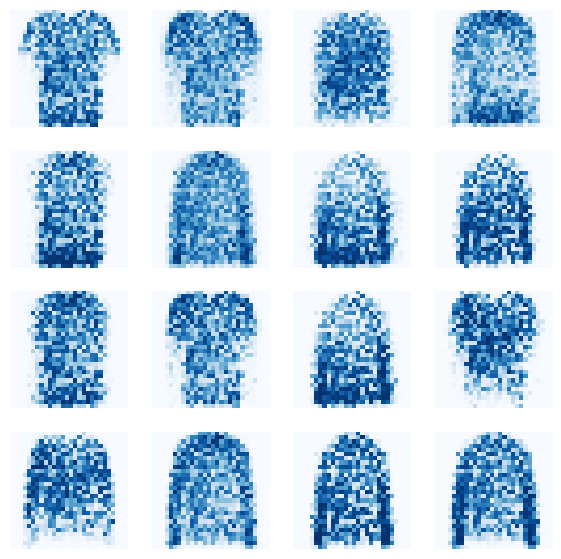

Epoch:3 Iter: 500 errD_x: 0.20 errD_z: 0.15 g_penalty: 39.68 errG: 2.49
Epoch:3 Iter: 1000 errD_x: 0.32 errD_z: 0.29 g_penalty: 57.41 errG: 2.32
Epoch:3 Iter: 1500 errD_x: 0.12 errD_z: 0.29 g_penalty: 95.44 errG: 2.33
Epoch:3 Iter: 2000 errD_x: 0.27 errD_z: 0.44 g_penalty: 55.27 errG: 1.86
Epoch:3 Iter: 2500 errD_x: 0.44 errD_z: 0.17 g_penalty: 96.83 errG: 2.76
Epoch:3 Iter: 3000 errD_x: 0.17 errD_z: 0.28 g_penalty: 62.11 errG: 2.27
Epoch:3 Iter: 3500 errD_x: 0.02 errD_z: 0.39 g_penalty: 43.83 errG: 2.60


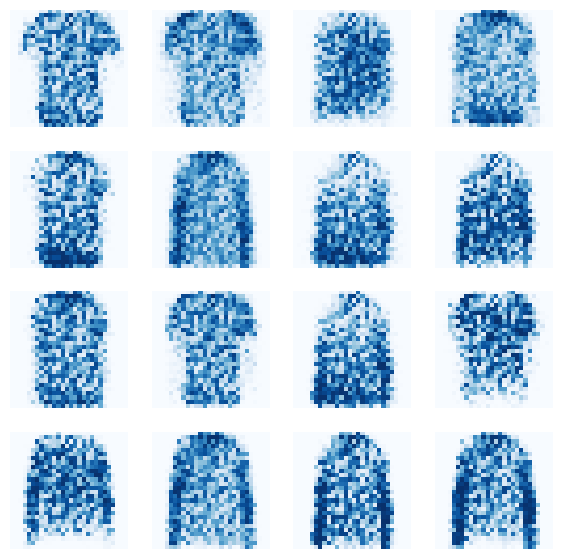

Epoch:4 Iter: 500 errD_x: 0.16 errD_z: 0.40 g_penalty: 59.87 errG: 2.06
Epoch:4 Iter: 1000 errD_x: 0.16 errD_z: 0.10 g_penalty: 35.08 errG: 2.49
Epoch:4 Iter: 1500 errD_x: 0.22 errD_z: 0.17 g_penalty: 40.44 errG: 3.18
Epoch:4 Iter: 2000 errD_x: 0.17 errD_z: 0.33 g_penalty: 29.70 errG: 2.72
Epoch:4 Iter: 2500 errD_x: 0.61 errD_z: 0.25 g_penalty: 95.37 errG: 2.09
Epoch:4 Iter: 3000 errD_x: 0.03 errD_z: 0.24 g_penalty: 110.77 errG: 2.65
Epoch:4 Iter: 3500 errD_x: 0.23 errD_z: 0.68 g_penalty: 107.09 errG: 1.12


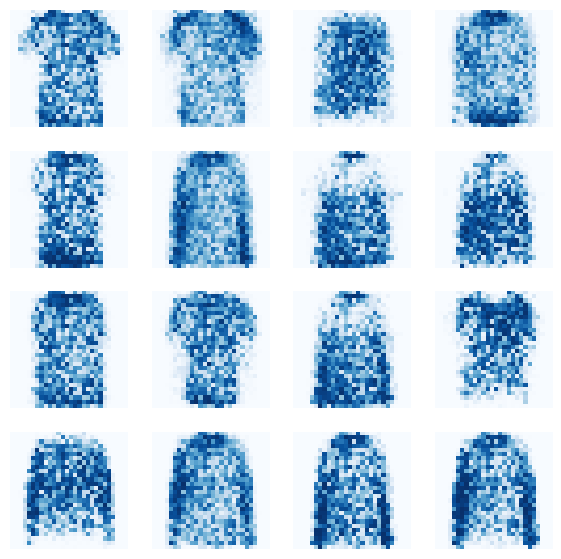

Epoch:5 Iter: 500 errD_x: 0.35 errD_z: 0.28 g_penalty: 32.64 errG: 2.75
Epoch:5 Iter: 1000 errD_x: 0.28 errD_z: 0.11 g_penalty: 72.61 errG: 3.21
Epoch:5 Iter: 1500 errD_x: 0.16 errD_z: 0.38 g_penalty: 8.21 errG: 2.09
Epoch:5 Iter: 2000 errD_x: 0.65 errD_z: 0.18 g_penalty: 58.66 errG: 2.68
Epoch:5 Iter: 2500 errD_x: 0.76 errD_z: 0.11 g_penalty: 34.23 errG: 2.22
Epoch:5 Iter: 3000 errD_x: 0.16 errD_z: 0.42 g_penalty: 50.21 errG: 1.87
Epoch:5 Iter: 3500 errD_x: 0.19 errD_z: 0.21 g_penalty: 75.61 errG: 2.83


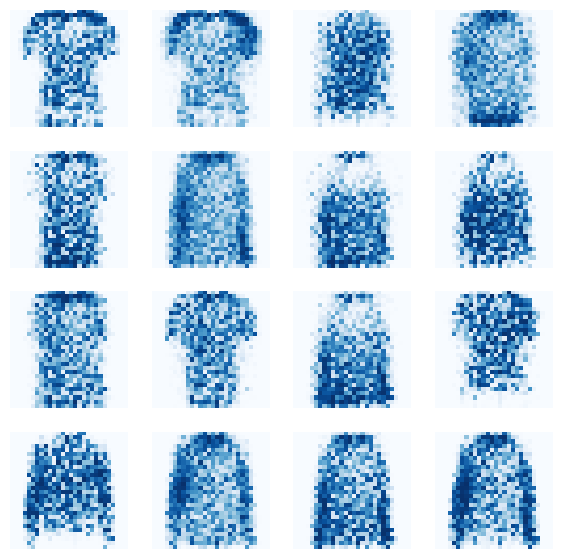

Epoch:6 Iter: 500 errD_x: 0.37 errD_z: 0.17 g_penalty: 65.27 errG: 2.61
Epoch:6 Iter: 1000 errD_x: 0.33 errD_z: 0.16 g_penalty: 133.95 errG: 2.48
Epoch:6 Iter: 1500 errD_x: 0.67 errD_z: 0.20 g_penalty: 56.90 errG: 2.77
Epoch:6 Iter: 2000 errD_x: 0.31 errD_z: 0.13 g_penalty: 69.99 errG: 2.82
Epoch:6 Iter: 2500 errD_x: 0.04 errD_z: 0.25 g_penalty: 57.34 errG: 2.30
Epoch:6 Iter: 3000 errD_x: 0.62 errD_z: 0.23 g_penalty: 75.05 errG: 2.11
Epoch:6 Iter: 3500 errD_x: 0.52 errD_z: 0.17 g_penalty: 182.45 errG: 2.96


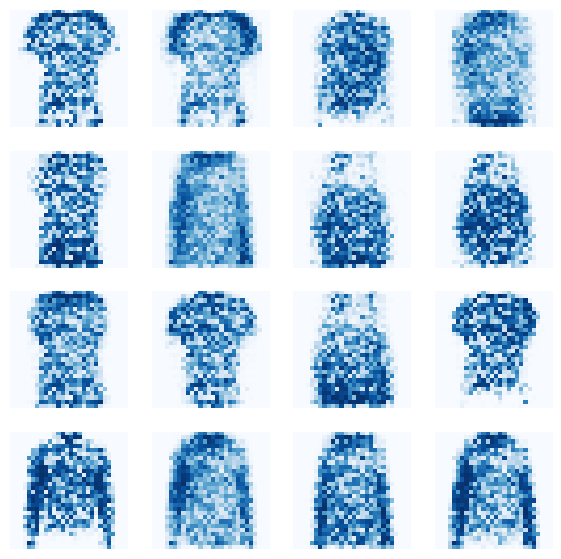

Epoch:7 Iter: 500 errD_x: 0.28 errD_z: 0.16 g_penalty: 38.74 errG: 3.07
Epoch:7 Iter: 1000 errD_x: 0.26 errD_z: 0.36 g_penalty: 117.57 errG: 1.87
Epoch:7 Iter: 1500 errD_x: 0.13 errD_z: 0.24 g_penalty: 83.44 errG: 2.92
Epoch:7 Iter: 2000 errD_x: 0.83 errD_z: 0.31 g_penalty: 124.63 errG: 1.96
Epoch:7 Iter: 2500 errD_x: 0.47 errD_z: 0.24 g_penalty: 108.37 errG: 2.84
Epoch:7 Iter: 3000 errD_x: 0.18 errD_z: 0.24 g_penalty: 47.44 errG: 2.09
Epoch:7 Iter: 3500 errD_x: 0.63 errD_z: 0.07 g_penalty: 10.54 errG: 3.03


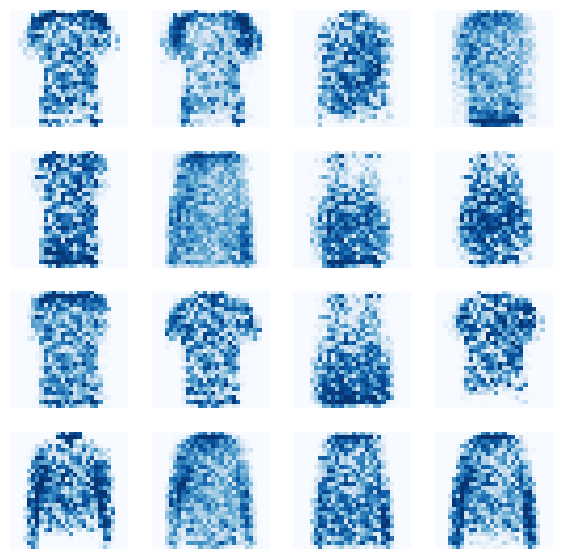

Epoch:8 Iter: 500 errD_x: 0.63 errD_z: 0.35 g_penalty: 115.99 errG: 2.08
Epoch:8 Iter: 1000 errD_x: 0.46 errD_z: 0.34 g_penalty: 61.37 errG: 2.34
Epoch:8 Iter: 1500 errD_x: 0.73 errD_z: 0.28 g_penalty: 94.65 errG: 2.37
Epoch:8 Iter: 2000 errD_x: 0.25 errD_z: 0.20 g_penalty: 49.92 errG: 3.44
Epoch:8 Iter: 2500 errD_x: 0.28 errD_z: 0.19 g_penalty: 44.90 errG: 2.62
Epoch:8 Iter: 3000 errD_x: 0.65 errD_z: 0.44 g_penalty: 258.38 errG: 1.61
Epoch:8 Iter: 3500 errD_x: 0.57 errD_z: 0.46 g_penalty: 126.69 errG: 2.50


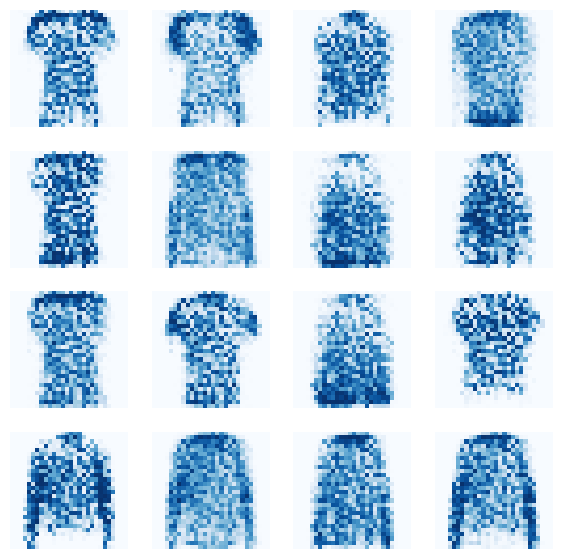

Epoch:9 Iter: 500 errD_x: 0.20 errD_z: 0.33 g_penalty: 79.02 errG: 1.82
Epoch:9 Iter: 1000 errD_x: 0.72 errD_z: 0.08 g_penalty: 46.99 errG: 2.56
Epoch:9 Iter: 1500 errD_x: 0.26 errD_z: 0.15 g_penalty: 60.32 errG: 2.57
Epoch:9 Iter: 2000 errD_x: 0.96 errD_z: 0.11 g_penalty: 34.44 errG: 2.74
Epoch:9 Iter: 2500 errD_x: 0.42 errD_z: 0.18 g_penalty: 42.58 errG: 2.42
Epoch:9 Iter: 3000 errD_x: 0.52 errD_z: 0.43 g_penalty: 69.94 errG: 1.68
Epoch:9 Iter: 3500 errD_x: 0.76 errD_z: 0.09 g_penalty: 58.85 errG: 3.05


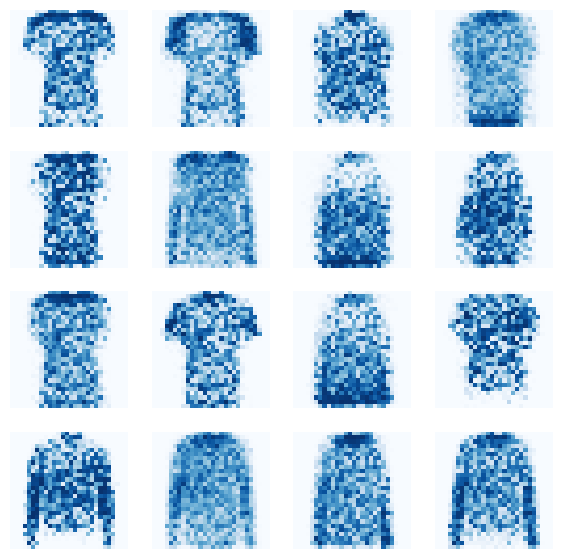

Epoch:10 Iter: 500 errD_x: 0.46 errD_z: 0.49 g_penalty: 231.04 errG: 1.54
Epoch:10 Iter: 1000 errD_x: 0.16 errD_z: 0.25 g_penalty: 133.49 errG: 1.98
Epoch:10 Iter: 1500 errD_x: 0.09 errD_z: 0.89 g_penalty: 176.18 errG: 1.23
Epoch:10 Iter: 2000 errD_x: 0.77 errD_z: 0.55 g_penalty: 93.09 errG: 1.66
Epoch:10 Iter: 2500 errD_x: 0.13 errD_z: 0.27 g_penalty: 145.89 errG: 2.69
Epoch:10 Iter: 3000 errD_x: 0.55 errD_z: 0.23 g_penalty: 311.36 errG: 1.55
Epoch:10 Iter: 3500 errD_x: 0.38 errD_z: 0.17 g_penalty: 87.25 errG: 2.27


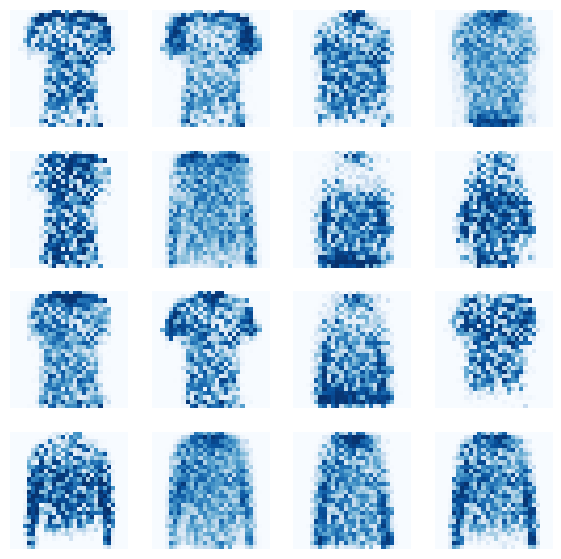

In [ ]:
ERRD_x = np.zeros(config.num_epochs)
ERRD_z = np.zeros(config.num_epochs)
ERRD_p = np.zeros(config.num_epochs)
ERRG = np.zeros(config.num_epochs)
N = len(dataloader)

# Loss weight for gradient penalty
lambda_gp = 10

for epoch in range(config.num_epochs):
    for iteration, (images, cat) in enumerate(dataloader):
        #######
        # Discriminator stage: maximize log(D(x)) + log(1 - D(G(z)))
        #######
        discriminator.zero_grad()

        # real
        label.data.fill_(real_label)
        input_data = images.view(images.shape[0], -1).to(DEVICE)
        output = discriminator(input_data).view(-1)
        errD_x = criterion(output, label)
        ERRD_x[epoch] += errD_x.item()
        errD_x.backward()

        # fake
        noise.data.normal_(0, 1)
        fake = generator(noise)
        label.data.fill_(fake_label)
        output = discriminator(fake.detach()).view(-1)
        errD_z = criterion(output, label)
        ERRD_z[epoch] += errD_z.item()
        errD_z.backward()

        optim_D.step()

        # Gradient penalty
        gradient_penalty = lambda_gp * compute_gradient_penalty(discriminator, input_data, fake)
        ERRD_p[epoch] += gradient_penalty.item()
        gradient_penalty.backward(retain_graph=True)

        #######
        # Generator stage: maximize log(D(G(x))
        #######
        generator.zero_grad()

        label.data.fill_(real_label)
        output = discriminator(fake).view(-1)
        errG = criterion(output, label)
        ERRG[epoch] += errG.item()
        errG.backward()

        optim_G.step()

        if (iteration+1) % config.print_freq == 0:
            print('Epoch:{} Iter: {} errD_x: {:.2f} errD_z: {:.2f} g_penalty: {:.2f} errG: {:.2f}'.format(epoch+1,
                                                                                            iteration+1,
                                                                                            errD_x.item(),
                                                                                            errD_z.item(),
                                                                                            gradient_penalty.item(),
                                                                                            errG.item()
                                                                                            )
            )
        # Show result with fix_noise
        if iteration == N-1: plot_gen_images(generator(fixed_noise))

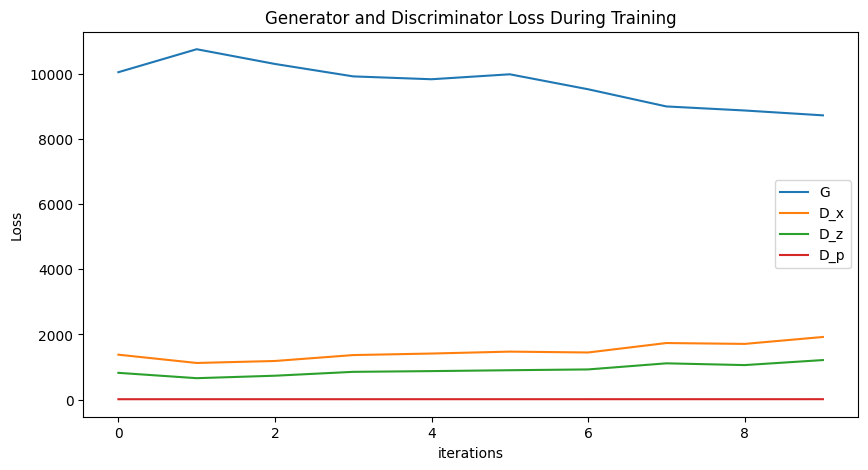

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(ERRG,label="G")
plt.plot(ERRD_x,label="D_x")
plt.plot(ERRD_z,label="D_z")
plt.plot(np.log(ERRD_p),label="D_p")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Комментарий

В целом, gradient_penalty, работает, но сама генерация не слишком отчичается от клипинга весов